In [1]:
# Dataset retirado de https://raw.githubusercontent.com/adamlamee/CODINGinK12/master/data/stars.csv
# Filtragem de distâncias muito grandes realizadas, corrigindo os outliers de estrelas supergigantes

In [2]:
# ===================== HR + CLUSTER (DATASET CUSTOM) =====================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import hdbscan

In [3]:
dataset_file = "stars.csv"

col_color = "ci"
col_mag = "absmag"
col_temp = "temp"
col_lum = "lum"

min_cluster_size = 40

In [4]:

# ---------------- 2) LER DADOS ----------------
df = pd.read_csv(dataset_file)
print("Shape original:", df.shape)

Shape original: (119614, 16)


In [5]:
# ---------------- 3) LIMPEZA BÁSICA ----------------
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=[col_color, col_mag, col_temp, col_lum])

# Filtros físicos razoáveis
df = df[df[col_color].between(-0.5, 3.5)]
df = df[df[col_mag].between(-15, 20)]
df = df[df[col_temp].between(2000, 50000)]
df = df[df[col_lum] > 0]

print("Após limpeza:", df.shape)

Após limpeza: (117699, 16)


In [6]:
# ---------------- 4) ESTIMAR RAIO (opcional) ----------------
# R/Rsun = sqrt(L / (T/Tsun)^4)
Tsun = 5772
df["radius_est"] = np.sqrt(df[col_lum] / ((df[col_temp] / Tsun) ** 4))

# ---------------- 5) IDENTIFICAR POSSÍVEIS ANÃS BRANCAS ----------------
# Critério simples:
#   alta magnitude absoluta (>= 10)
#   cor azul (ci < 0.5)
df["white_dwarf_flag"] = (
    (df[col_mag] > 10) &
    (df[col_color] < 0.5)
)



In [7]:
df = df[df["dist"] < 5000] # Correção de distância, para evitar outliers absurdos
df = df.sample(50000, random_state=56)

In [8]:
# ---------------- 6) CLUSTERIZAÇÃO ----------------
features = df[[col_mag, col_color, col_temp]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
df["cluster"] = clusterer.fit_predict(X_scaled)


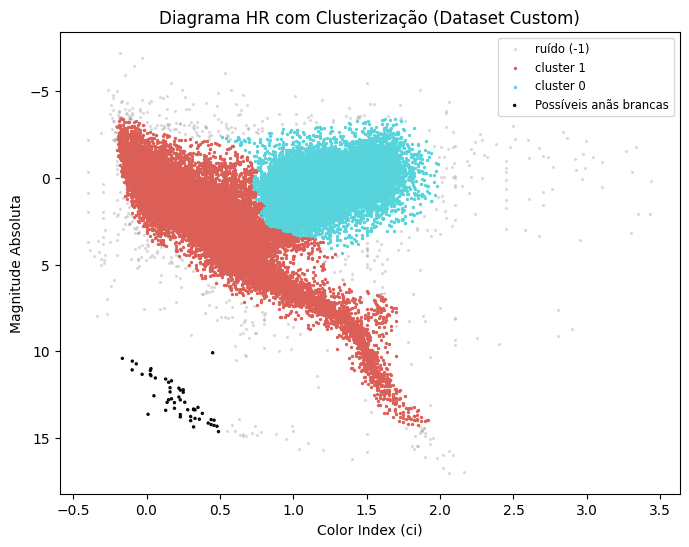

In [ ]:

# ---------------- 7) PLOT HR COM CLUSTER ----------------

plt.figure(figsize=(8, 6))

# Separar clusters
clusters_valid = [c for c in df["cluster"].unique() if c != -1]

palette = sns.color_palette("hls", len(clusters_valid))
cluster_colors = {c: palette[i] for i, c in enumerate(clusters_valid)}
cluster_colors[-1] = (0.5, 0.5, 0.5)

# Plot ruído transparente
noise = df[df["cluster"] == -1]
plt.scatter(noise[col_color], noise[col_mag],
            c=[cluster_colors[-1]],
            alpha=0.2, s=2, label="ruído (-1)")

# Plot clusters válidos
for c in clusters_valid:
    subset = df[df["cluster"] == c]
    plt.scatter(subset[col_color], subset[col_mag],
                c=[cluster_colors[c]],
                s=2, alpha=1, label=f"cluster {c}")

# Destacar anãs brancas
wd = df[df["white_dwarf_flag"]]
plt.scatter(wd[col_color], wd[col_mag],
            edgecolors="black",
            facecolors="none",
            s=2,
            label="Possíveis anãs brancas")

plt.gca().invert_yaxis()
plt.xlabel("Color Index (ci)")
plt.ylabel("Magnitude Absoluta")
plt.title("Diagrama HR com Clusterização (Dataset Custom)")
plt.legend(markerscale=1, fontsize="small", loc="best")
plt.show()


In [10]:
df.describe()

,ra,dec,dist,mag,absmag,ci,temp,x,y,z,lum,var_min,var_max,radius_est,cluster
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,6130.000000,6130.000000,50000.000000,50000.000000
mean,12.084472,-1.977288,248.110354,8.324568,2.015465,0.702918,6178.732533,-1.105877,1.094039,-6.743258,66.717183,9.310654,9.104199,7.057212,0.638760
std,6.891273,41.101074,190.428853,1.360067,2.282665,0.476895,2005.561287,164.860454,180.843568,194.658335,489.602661,1.831488,1.817286,10.469914,0.504768
min,0.000335,-89.782428,1.295900,-1.440000,-7.223000,-0.400000,2160.956030,-975.513096,-958.545344,-978.837073,0.000014,-1.333000,-1.523000,0.005814,-1.000000
25%,6.170265,-36.486187,110.011000,7.590000,0.522000,0.362000,4594.149429,-78.614076,-80.442991,-95.318913,4.377236,8.263000,7.987250,1.601510,0.000000
50%,12.169580,-1.739996,196.463700,8.390000,1.704000,0.607000,5940.269764,-0.532688,-1.483167,-3.549216,18.130092,9.744500,9.557500,2.744772,1.000000
75%,18.104603,31.281808,330.033000,9.090000,3.247000,1.064000,7089.281444,77.355751,81.206316,85.190489,53.851772,10.580000,10.404500,8.927765,1.000000
max,23.998594,89.569427,990.099000,17.820000,17.013000,3.440000,21707.421710,953.335847,966.239750,949.040689,67483.873090,14.245000,12.612000,294.588513,1.000000
